In [1]:
%load_ext autoreload
%autoreload 2

# Imports

In [2]:
import pickle

import numpy as np
from matplotlib.colors import LogNorm
from fluxes import power_law
from mephisto import plot_mephistogram
from settings import *

# Preparations

In [3]:
# need to run once in the beginning to prepare all ingredients for the analysis
# this might take several minutes

# run these only if you haven't done so before
# calculate the atmospheric neutrino background using MCEq (IceCube-centric)
# %run ../../core/atmospheric_background.py

# run these every time there are updates to resolution, binning, or mephistograms
# load and prepare the energy and angular resolutions
%run ../../core/resolution.py

# gather all ingredients and save them as unified 'mephistogram' data structure
%run ../../core/prepare_histograms.py

file exists: /home/lisajsch/repos/Plenum/local/e_psf_grid_psimax-3_bins-25.pckl
file exists: /home/lisajsch/repos/Plenum/local/energy_smearing_2D_step-0.1.pckl
140 log_10(energy) bins
100 declination bins
140 log_10(energy) bins
100 declination bins
Elementary arithmetic possible.
True


# Default binning

In [3]:
print(len(logE_bins), np.min(logE_bins), np.max(logE_bins))
print(len(logE_reco_bins), np.min(logE_reco_bins), np.max(logE_reco_bins))
print(len(sindec_bins), np.min(sindec_bins), np.max(sindec_bins))


141 2.0 8.999999999999975
140 2.0 8.949999999999974
101 -1.0 1.0


# Background

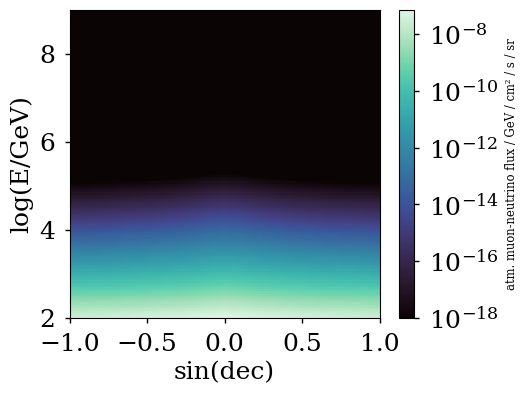

In [8]:
# MCEQ: atmospheric flux on muon neutrinos (see also 'background_flux.ipynb')
with open(join(LOCALPATH, "atmospheric_background_MH.pckl"), "rb") as f:
    bckg_histo = pickle.load(f)

# visualization of bckg flux
plot_mephistogram(bckg_histo, norm=LogNorm(vmin=1E-18))
cb = plt.gca().collections[0].colorbar
cb.set_label("atm. muon-neutrino flux / GeV / cm² / s / sr", fontsize="small")


# Load underlying mceq flux

In [10]:
# MCEQ atmospheric background
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bckg_flux = pickle.load(f)


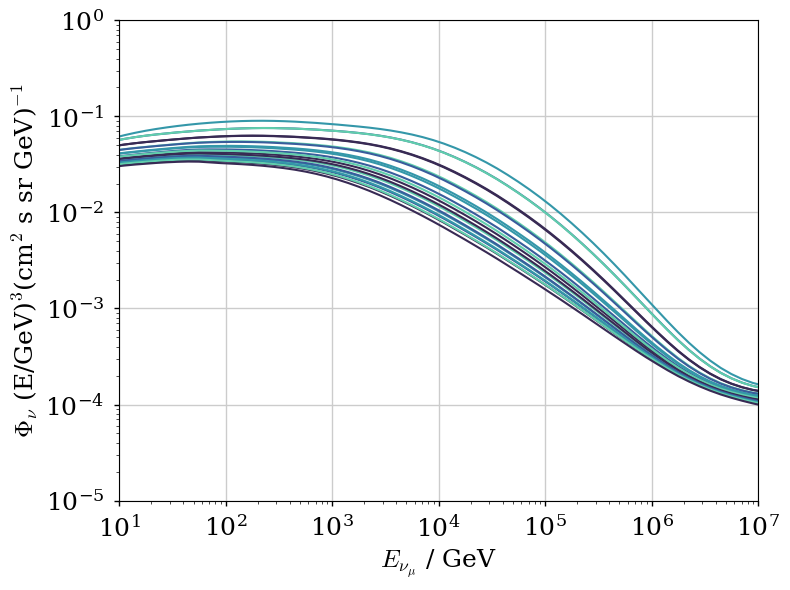

In [11]:
spec = 3
fig, ax = plt.subplots(figsize=(8, 6))
for ti, _ in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):

        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * bckg_flux[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )

ax.set_xlim(10, 1e7)
ax.set_ylim(1e-5, 1)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


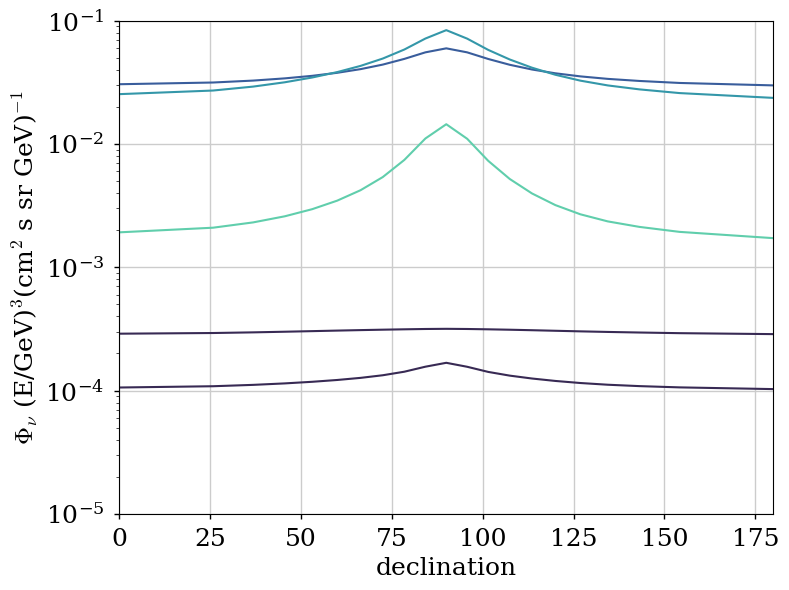

In [16]:
spec = 3
fig, ax = plt.subplots(figsize=(8, 6))
for ei, cur_e in enumerate(e_grid):
    if ei%20!=0: continue
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):

        p0 = ax.plot(
            zen,
            cur_e ** (spec) * bckg_flux[pref + "total"][ei],
            ls="solid",
            lw=1.5,
        )

ax.set_xlim(0, 180)
ax.set_yscale("log")
ax.set_ylim(1e-5, 0.1)
ax.set_xlabel("declination")
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()


## With astro flux, as comparison

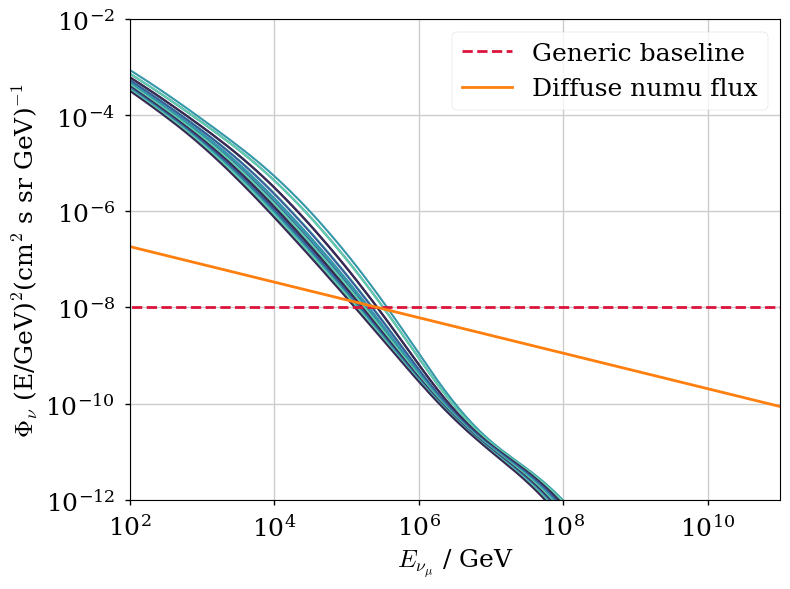

In [8]:
spec = 2
fig, ax = plt.subplots(figsize=(8, 6))
for ti, ang in enumerate(zen):
    for i, (pref, lab) in enumerate([("numu_", r"\nu_\mu")]):
        p0 = ax.loglog(
            e_grid,
            e_grid ** (spec) * bckg_flux[pref + "total"][:, ti],
            ls="solid",
            lw=1.5,
        )
ax.loglog(
    e_grid,
    power_law(e_grid, 1e5, 2, 1e-18) * e_grid ** (spec),
    label="Generic baseline",
    color="crimson",
    ls="--",
)  # generic baseline spectrum ~E^-2
ax.loglog(
    e_grid,
    power_law(e_grid, 1e5, GAMMA_ASTRO, PHI_ASTRO) * e_grid ** (spec),
    label="Diffuse numu flux",
    color="tab:orange",
)  # best-fit numu
ax.legend()
ax.set_xlim(1e2, 1e11)
ax.set_ylim(1e-12, 1e-2)
ax.set_xlabel(r"$E_{{{0}}}$ / GeV".format(lab))
ax.set_ylabel(
    r"$\Phi_{\nu}$ (E/GeV)$^{" + str(spec) + " }$" + "(cm$^{2}$ s sr GeV)$^{-1}$"
)
fig.tight_layout()
